In [1]:
reset -fs

In [7]:
#For plotting
import matplotlib.pyplot as plt
#for matrix math
import numpy as np
#for normalization + probability density function computation
from scipy import stats
#for plotting
import seaborn as sns
#for data preprocessing
import pandas as pd

sns.set_style("white")
%matplotlib inline

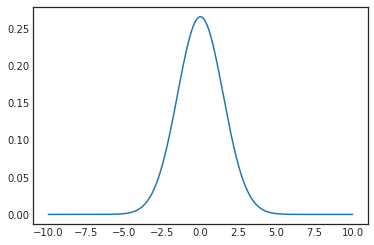

In [8]:
#Return evenly spaced numbers over a specified interval.
x = np.linspace(start=-10, stop=10, num=1000)
#A normal continuous random variable.
#The location (loc) keyword specifies the mean. The scale (scale) keyword specifies the standard deviation.
y = stats.norm.pdf(x, loc=0, scale=1.5) 
#plot it!
plt.plot(x, y)

In [32]:
# get data from the spatialite database
import sqlite3
import matplotlib.pyplot as plt
import geopandas as gpd
from binascii import unhexlify
from codecs import encode
import pysal

db_name = "../Goali/OSM_database/data/USA_osm.db"

conn = sqlite3.connect(db_name)
conn.enable_load_extension(True)
conn.load_extension("mod_spatialite")

query = """
        SELECT ac.HOUR, ac.MONTH, ac.COUNTY, ac.DAY_WEEK, ac.ROAD_FNC, ac.ROUTE
        FROM Fatal_Motor_Vehicle_Accidents as ac
        WHERE ac.HOUR<99
        
        """
accident_data = pd.read_sql(query, conn)
accident_data.head(5)

data = accident_data.HOUR

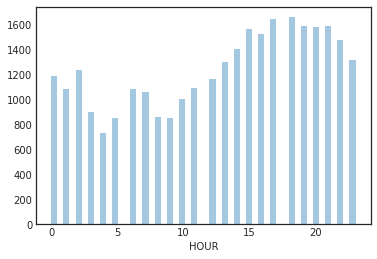

In [20]:
#plot histogram
sns.distplot(accident_data.HOUR, bins=50, kde=False)

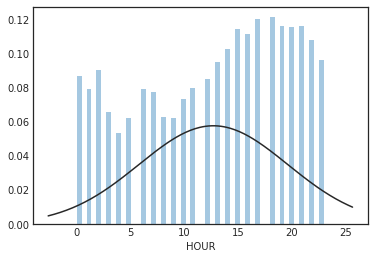

In [21]:
#try to fit a normal distribution to this data
sns.distplot(accident_data.HOUR, fit=stats.norm, bins=50, kde=False,)

In [39]:
class Gaussian:
    "Model univariate Gaussian"
    def __init__(self, mu, sigma):
        #mean and standard deviation
        self.mu = mu
        self.sigma = sigma

    #probability density function
    def pdf(self, datum):
        "Probability of a data point given the current parameters"
        u = (datum - self.mu) / abs(self.sigma)
        y = (1 / (sqrt(2 * pi) * abs(self.sigma))) * exp(-u * u / 2)
        return y
    #printing model values
    def __repr__(self):
        return 'Gaussian({0:4.6}, {1:4.6})'.format(self.mu, self.sigma)

In [40]:
#gaussian of best fit
best_single = Gaussian(np.mean(accident_data.HOUR), np.std(accident_data.HOUR))
print('Best single Gaussian: μ = {:.2}, σ = {:.2}'.format(best_single.mu, best_single.sigma))

Best single Gaussian: μ = 1.3e+01, σ = 6.9


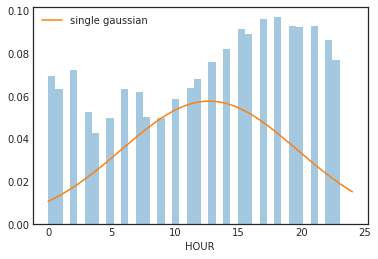

In [41]:
#fit a single gaussian curve to the data
x = np.linspace(0, 24, 200)
g_single = stats.norm(best_single.mu, best_single.sigma).pdf(x)
sns.distplot(data, bins=40, kde=False, norm_hist=True)
plt.plot(x, g_single, label='single gaussian')
plt.legend();

In [42]:
from math import sqrt, log, exp, pi
from random import uniform

In [70]:
class GaussianMixture:
    "Model mixture of two univariate Gaussians and their EM estimation"

    def __init__(self, data, mu_min=min(data), mu_max=max(data), sigma_min=.1, sigma_max=1, mix=.5):
        self.data = data
        #init with multiple gaussians
        self.one = Gaussian(uniform(mu_min, mu_max), 
                            uniform(sigma_min, sigma_max))
        self.two = Gaussian(uniform(mu_min, mu_max), 
                            uniform(sigma_min, sigma_max))
        
        #as well as how much to mix them
        self.mix = mix
        self.loglike = 0. # = log(p = 1)
    def Estep(self):
        "Perform an E(stimation)-step, freshening up self.loglike in the process"
        # compute weights
        #self.loglike = 0. # = log(p = 1)
        for datum in self.data:
            # unnormalized weights
            wp1 = self.one.pdf(datum) * self.mix
            wp2 = self.two.pdf(datum) * (1. - self.mix)
            # compute denominator
            den = wp1 + wp2
            # normalize
            wp1 /= den
            wp2 /= den
            # add into loglike
            self.loglike += log(wp1 + wp2)
            # yield weight tuple
            yield (wp1, wp2)

    def Mstep(self, weights):
        "Perform an M(aximization)-step"
        # compute denominators
        (left, rigt) = zip(*weights)
        one_den = sum(left)
        two_den = sum(rigt)
        # compute new means
        self.one.mu = sum(w * d / one_den for (w, d) in zip(left, data))
        self.two.mu = sum(w * d / two_den for (w, d) in zip(rigt, data))
        # compute new sigmas
        self.one.sigma = sqrt(sum(w * ((d - self.one.mu) ** 2)
                                  for (w, d) in zip(left, data)) / one_den)
        self.two.sigma = sqrt(sum(w * ((d - self.two.mu) ** 2)
                                  for (w, d) in zip(rigt, data)) / two_den)
        # compute new mix
        self.mix = one_den / len(data)

    def iterate(self, N=1, verbose=False):
        "Perform N iterations, then compute log-likelihood"
        for i in range(1, N+1):
            self.Mstep(self.Estep())
            if verbose:
                print('{0:2} {1}'.format(i, self))
        self.Estep() # to freshen up self.loglike
        
    def pdf(self, x):
        return (self.mix)*self.one.pdf(x) + (1-self.mix)*self.two.pdf(x)
        
    def __repr__(self):
        return 'GaussianMixture({0}, {1}, mix={2.03})'.format(self.one, 
                                                              self.two, 
                                                              self.mix)

    def __str__(self):
        return 'Mixture: {0}, {1}, mix={2:.03})'.format(self.one, 
                                                        self.two, 
                                                        self.mix)

In [ ]:
# Find best Mixture Gaussian model
n_iterations = 20
n_random_restarts = 500
best_mix = None
best_loglike = float('-inf')
print('Computing best model with random restarts...\n')
for _ in range(n_random_restarts):
    mix = GaussianMixture(data)
    for _ in range(n_iterations):
        try:
            mix.iterate(verbose=True)
            if mix.loglike > best_loglike:
                best_loglike = mix.loglike
                best_mix = mix
        except (ZeroDivisionError, ValueError, RuntimeWarning): # Catch division errors from bad starts, and just throw them out...
            pass
print('\n\nDone. 🙂')
print(best_mix)

Computing best model with random restarts...

 1 Mixture: Gaussian(12.9065, 7.48744), Gaussian(11.6053, 1.11835), mix=0.847)
 1 Mixture: Gaussian(12.7865, 7.17863), Gaussian(11.7239, 1.29174), mix=0.925)
 1 Mixture: Gaussian(12.7463, 7.06973), Gaussian(11.8615, 1.39916), mix=0.955)
 1 Mixture: Gaussian(12.7273, 7.01525), Gaussian(12.0175, 1.47933), mix=0.971)
 1 Mixture: Gaussian(12.7171, 6.98385), Gaussian(12.1922, 1.54526), mix=0.98)
 1 Mixture: Gaussian(12.7114, 6.96432), Gaussian(12.3863, 1.60251), mix=0.986)
 1 Mixture: Gaussian(12.708, 6.95162), Gaussian(12.6005, 1.65363), mix=0.99)
 1 Mixture: Gaussian(12.706, 6.94309), Gaussian(12.8354, 1.69967), mix=0.993)
 1 Mixture: Gaussian(12.7047, 6.93724), Gaussian(13.091, 1.74102), mix=0.994)
 1 Mixture: Gaussian(12.704, 6.93315), Gaussian(13.367, 1.77771), mix=0.996)
 1 Mixture: Gaussian(12.7035, 6.93025), Gaussian(13.6624, 1.80979), mix=0.996)
 1 Mixture: Gaussian(12.7032, 6.92818), Gaussian(13.976, 1.83743), mix=0.997)
 1 Mixture: Ga

 1 Mixture: Gaussian(21.4307, 1.15287), Gaussian(11.3788, 6.45063), mix=0.132)
 1 Mixture: Gaussian(21.3391, 1.20721), Gaussian(11.325, 6.43947), mix=0.138)
 1 Mixture: Gaussian(21.2504, 1.26122), Gaussian(11.264, 6.42508), mix=0.144)
 1 Mixture: Gaussian(21.1633, 1.31514), Gaussian(11.1986, 6.40899), mix=0.151)
 1 Mixture: Gaussian(21.0773, 1.36905), Gaussian(11.1304, 6.39194), mix=0.158)
 1 Mixture: Gaussian(20.9919, 1.42296), Gaussian(11.0601, 6.37432), mix=0.166)
 1 Mixture: Gaussian(20.9071, 1.47677), Gaussian(10.988, 6.35631), mix=0.173)
 1 Mixture: Gaussian(20.823, 1.53032), Gaussian(10.9145, 6.33798), mix=0.181)
 1 Mixture: Gaussian(20.7397, 1.58343), Gaussian(10.8397, 6.31936), mix=0.189)
 1 Mixture: Gaussian(20.6575, 1.63589), Gaussian(10.7637, 6.30045), mix=0.196)
 1 Mixture: Gaussian(20.5768, 1.68751), Gaussian(10.6869, 6.28122), mix=0.204)
 1 Mixture: Gaussian(20.4978, 1.73811), Gaussian(10.6093, 6.26168), mix=0.212)
 1 Mixture: Gaussian(20.4207, 1.78753), Gaussian(10.5313

 1 Mixture: Gaussian(19.5983, 2.31998), Gaussian(9.49503, 5.93531), mix=0.318)
 1 Mixture: Gaussian(19.5538, 2.34876), Gaussian(9.43215, 5.91502), mix=0.324)
 1 Mixture: Gaussian(19.5116, 2.37594), Gaussian(9.36955, 5.89389), mix=0.329)
 1 Mixture: Gaussian(19.4715, 2.40172), Gaussian(9.30761, 5.87224), mix=0.334)
 1 Mixture: Gaussian(19.4332, 2.42626), Gaussian(9.24655, 5.85028), mix=0.34)
 1 Mixture: Gaussian(19.3964, 2.44969), Gaussian(9.18652, 5.82816), mix=0.345)
 1 Mixture: Gaussian(19.3612, 2.47211), Gaussian(9.12757, 5.80596), mix=0.35)
 1 Mixture: Gaussian(19.3273, 2.4936), Gaussian(9.06972, 5.78373), mix=0.355)
 1 Mixture: Gaussian(19.2946, 2.51423), Gaussian(9.01299, 5.76153), mix=0.359)
 1 Mixture: Gaussian(19.263, 2.53406), Gaussian(8.95735, 5.73937), mix=0.364)
 1 Mixture: Gaussian(19.2325, 2.55315), Gaussian(8.90278, 5.71728), mix=0.368)
 1 Mixture: Gaussian(5.94537, 3.26127), Gaussian(16.5409, 5.32602), mix=0.362)
 1 Mixture: Gaussian(4.92309, 3.6653), Gaussian(16.5865,

 1 Mixture: Gaussian(15.0, 7.15872e-13), Gaussian(12.5798, 7.08666), mix=0.0525)
 1 Mixture: Gaussian(15.0, 9.05942e-13), Gaussian(12.5798, 7.08666), mix=0.0525)
 1 Mixture: Gaussian(15.0, 7.15872e-13), Gaussian(12.5798, 7.08666), mix=0.0525)
 1 Mixture: Gaussian(15.0, 9.05942e-13), Gaussian(12.5798, 7.08666), mix=0.0525)
 1 Mixture: Gaussian(15.0, 7.15872e-13), Gaussian(12.5798, 7.08666), mix=0.0525)
 1 Mixture: Gaussian(15.0, 9.05942e-13), Gaussian(12.5798, 7.08666), mix=0.0525)
 1 Mixture: Gaussian(19.3964, 2.24255), Gaussian(7.94091, 4.87879), mix=0.416)
 1 Mixture: Gaussian(19.2373, 2.48245), Gaussian(8.21558, 5.20191), mix=0.407)
 1 Mixture: Gaussian(19.1233, 2.58861), Gaussian(8.30592, 5.3393), mix=0.407)
 1 Mixture: Gaussian(19.0475, 2.64953), Gaussian(8.32987, 5.4005), mix=0.408)
 1 Mixture: Gaussian(18.9943, 2.68916), Gaussian(8.32259, 5.4247), mix=0.411)
 1 Mixture: Gaussian(18.9542, 2.71737), Gaussian(8.29918, 5.42933), mix=0.414)
 1 Mixture: Gaussian(18.9218, 2.73908), Gau

 1 Mixture: Gaussian(18.2743, 3.11092), Gaussian(7.01783, 4.78198), mix=0.505)
 1 Mixture: Gaussian(18.2559, 3.12112), Gaussian(6.98241, 4.76215), mix=0.508)
 1 Mixture: Gaussian(5.94696, 3.8938), Gaussian(18.028, 3.05602), mix=0.44)
 1 Mixture: Gaussian(6.07332, 4.13973), Gaussian(17.8873, 3.26746), mix=0.438)
 1 Mixture: Gaussian(6.094, 4.21174), Gaussian(17.8245, 3.34129), mix=0.436)
 1 Mixture: Gaussian(6.08414, 4.229), Gaussian(17.79, 3.37496), mix=0.434)
 1 Mixture: Gaussian(6.0633, 4.22591), Gaussian(17.7666, 3.3939), mix=0.432)
 1 Mixture: Gaussian(6.03836, 4.21489), Gaussian(17.7479, 3.40699), mix=0.431)
 1 Mixture: Gaussian(6.01197, 4.20077), Gaussian(17.731, 3.41767), mix=0.429)
 1 Mixture: Gaussian(5.98521, 4.18551), Gaussian(17.7151, 3.42734), mix=0.427)
 1 Mixture: Gaussian(5.95851, 4.1699), Gaussian(17.6996, 3.43655), mix=0.425)
 1 Mixture: Gaussian(5.93205, 4.15426), Gaussian(17.6843, 3.44553), mix=0.424)
 1 Mixture: Gaussian(5.90589, 4.13873), Gaussian(17.6693, 3.45437

 1 Mixture: Gaussian(0.860068, 0.801545), Gaussian(13.7896, 6.17996), mix=0.0837)
 1 Mixture: Gaussian(0.975726, 0.863973), Gaussian(13.8967, 6.10577), mix=0.0921)
 1 Mixture: Gaussian(1.07648, 0.925207), Gaussian(13.9968, 6.03512), mix=0.0998)
 1 Mixture: Gaussian(1.16721, 0.983031), Gaussian(14.0883, 5.96995), mix=0.107)
 1 Mixture: Gaussian(1.24683, 1.03488), Gaussian(14.17, 5.91114), mix=0.113)
 1 Mixture: Gaussian(1.31468, 1.0809), Gaussian(14.2405, 5.85995), mix=0.119)
 1 Mixture: Gaussian(1.37253, 1.12207), Gaussian(14.3001, 5.81645), mix=0.123)
 1 Mixture: Gaussian(1.42264, 1.15915), Gaussian(14.3504, 5.77964), mix=0.127)
 1 Mixture: Gaussian(1.46676, 1.19272), Gaussian(14.3935, 5.74821), mix=0.13)
 1 Mixture: Gaussian(1.50613, 1.22327), Gaussian(14.4309, 5.72103), mix=0.133)
 1 Mixture: Gaussian(1.54163, 1.25125), Gaussian(14.4638, 5.6972), mix=0.136)
 1 Mixture: Gaussian(1.57398, 1.27707), Gaussian(14.4931, 5.67603), mix=0.138)
 1 Mixture: Gaussian(1.60377, 1.30108), Gaussian

 1 Mixture: Gaussian(11.3992, 1.74181), Gaussian(12.7123, 6.9319), mix=0.00408)
 1 Mixture: Gaussian(11.5755, 1.82235), Gaussian(12.7101, 6.92794), mix=0.00281)
 1 Mixture: Gaussian(11.7794, 1.9073), Gaussian(12.7087, 6.92531), mix=0.00197)
 1 Mixture: Gaussian(12.0161, 1.99629), Gaussian(12.7079, 6.92355), mix=0.00141)
 1 Mixture: Gaussian(12.2918, 2.08827), Gaussian(12.7073, 6.92235), mix=0.00103)
 1 Mixture: Gaussian(12.6128, 2.18152), Gaussian(12.707, 6.92152), mix=0.000768)
 1 Mixture: Gaussian(12.9855, 2.27372), Gaussian(12.7067, 6.92095), mix=0.000592)
 1 Mixture: Gaussian(13.4155, 2.36209), Gaussian(12.7066, 6.92056), mix=0.000472)
 1 Mixture: Gaussian(13.9068, 2.44368), Gaussian(12.7064, 6.92028), mix=0.000393)
 1 Mixture: Gaussian(14.4606, 2.51549), Gaussian(12.7063, 6.92008), mix=0.000343)
 1 Mixture: Gaussian(15.0739, 2.57387), Gaussian(12.7062, 6.91994), mix=0.000317)
 1 Mixture: Gaussian(15.7369, 2.61297), Gaussian(12.706, 6.91985), mix=0.000311)
 1 Mixture: Gaussian(16.4

 1 Mixture: Gaussian(16.3425, 4.3328), Gaussian(3.85513, 2.86216), mix=0.709)
 1 Mixture: Gaussian(16.3633, 4.3175), Gaussian(3.8824, 2.87927), mix=0.707)
 1 Mixture: Gaussian(16.3831, 4.3029), Gaussian(3.90864, 2.89575), mix=0.705)
 1 Mixture: Gaussian(16.4021, 4.28896), Gaussian(3.93388, 2.91163), mix=0.704)
 1 Mixture: Gaussian(16.4203, 4.27565), Gaussian(3.95818, 2.92693), mix=0.702)
 1 Mixture: Gaussian(16.4377, 4.26294), Gaussian(3.98156, 2.94167), mix=0.7)
 1 Mixture: Gaussian(16.4544, 4.25079), Gaussian(4.00408, 2.95588), mix=0.699)
 1 Mixture: Gaussian(16.4704, 4.23918), Gaussian(4.02575, 2.96957), mix=0.698)
 1 Mixture: Gaussian(16.4857, 4.22807), Gaussian(4.04662, 2.98276), mix=0.696)
 1 Mixture: Gaussian(5.35763, 3.56717), Gaussian(17.6343, 3.3089), mix=0.401)
 1 Mixture: Gaussian(5.4577, 3.79166), Gaussian(17.502, 3.5041), mix=0.398)
 1 Mixture: Gaussian(5.47535, 3.85212), Gaussian(17.4516, 3.56729), mix=0.396)
 1 Mixture: Gaussian(5.46915, 3.86561), Gaussian(17.4264, 3.59

 1 Mixture: Gaussian(2.58615, 2.07243), Gaussian(15.2504, 5.15894), mix=0.201)
 1 Mixture: Gaussian(2.6257, 2.09386), Gaussian(15.3086, 5.10888), mix=0.205)
 1 Mixture: Gaussian(2.67325, 2.1235), Gaussian(15.3578, 5.07011), mix=0.209)
 1 Mixture: Gaussian(2.72441, 2.15653), Gaussian(15.404, 5.03532), mix=0.213)
 1 Mixture: Gaussian(5.35913, 3.56796), Gaussian(17.6354, 3.30813), mix=0.401)
 1 Mixture: Gaussian(5.4593, 3.79257), Gaussian(17.503, 3.50343), mix=0.398)
 1 Mixture: Gaussian(5.47695, 3.85307), Gaussian(17.4526, 3.56667), mix=0.396)
 1 Mixture: Gaussian(5.47074, 3.86657), Gaussian(17.4274, 3.59316), mix=0.395)
 1 Mixture: Gaussian(5.45654, 3.86416), Gaussian(17.4111, 3.60714), mix=0.394)
 1 Mixture: Gaussian(5.43969, 3.85616), Gaussian(17.3982, 3.61656), mix=0.392)
 1 Mixture: Gaussian(5.42207, 3.84624), Gaussian(17.3866, 3.62425), mix=0.391)
 1 Mixture: Gaussian(5.4044, 3.83574), Gaussian(17.3756, 3.63123), mix=0.39)
 1 Mixture: Gaussian(5.38692, 3.82516), Gaussian(17.3649, 3

 1 Mixture: Gaussian(14.0641, 8.63258), Gaussian(11.1291, 3.50215), mix=0.538)
 1 Mixture: Gaussian(13.3806, 7.80337), Gaussian(11.4842, 4.68289), mix=0.645)
 1 Mixture: Gaussian(13.1382, 7.36754), Gaussian(11.8113, 5.77776), mix=0.675)
 1 Mixture: Gaussian(13.0211, 7.09066), Gaussian(12.0363, 6.48734), mix=0.681)
 1 Mixture: Gaussian(12.975, 6.94979), Gaussian(12.1324, 6.81758), mix=0.682)
 1 Mixture: Gaussian(12.9661, 6.88847), Gaussian(12.1514, 6.95192), mix=0.682)
 1 Mixture: Gaussian(12.9733, 6.86186), Gaussian(12.1359, 7.00626), mix=0.682)
 1 Mixture: Gaussian(12.9874, 6.84861), Gaussian(12.1058, 7.03028), mix=0.682)
 1 Mixture: Gaussian(13.0048, 6.84014), Gaussian(12.0689, 7.0431), mix=0.682)
 1 Mixture: Gaussian(13.0239, 6.8332), Gaussian(12.028, 7.05187), mix=0.682)
 1 Mixture: Gaussian(13.0445, 6.82655), Gaussian(11.9842, 7.05918), mix=0.682)
 1 Mixture: Gaussian(13.0664, 6.81973), Gaussian(11.9377, 7.06598), mix=0.681)
 1 Mixture: Gaussian(13.0896, 6.81254), Gaussian(11.8886

 1 Mixture: Gaussian(13.0591, 6.77211), Gaussian(2.65612, 0.866886), mix=0.966)
 1 Mixture: Gaussian(13.1715, 6.70469), Gaussian(2.34622, 0.93139), mix=0.957)
 1 Mixture: Gaussian(13.3522, 6.58735), Gaussian(2.02273, 1.00805), mix=0.943)
 1 Mixture: Gaussian(13.6195, 6.39316), Gaussian(1.70429, 1.09024), mix=0.923)
 1 Mixture: Gaussian(13.9252, 6.14665), Gaussian(1.48799, 1.13224), mix=0.902)
 1 Mixture: Gaussian(14.1521, 5.95282), Gaussian(1.42048, 1.14627), mix=0.886)
 1 Mixture: Gaussian(14.284, 5.84), Gaussian(1.42903, 1.16391), mix=0.877)
 1 Mixture: Gaussian(14.3611, 5.7765), Gaussian(1.46052, 1.1887), mix=0.872)
 1 Mixture: Gaussian(14.4122, 5.73641), Gaussian(1.49642, 1.21613), mix=0.868)
 1 Mixture: Gaussian(14.4509, 5.70723), Gaussian(1.53137, 1.24333), mix=0.865)
 1 Mixture: Gaussian(14.4829, 5.68365), Gaussian(1.56407, 1.26921), mix=0.863)
 1 Mixture: Gaussian(14.5108, 5.66338), Gaussian(1.59441, 1.29355), mix=0.86)
 1 Mixture: Gaussian(14.5359, 5.64532), Gaussian(1.62267, 

 1 Mixture: Gaussian(4.86897, 3.50377), Gaussian(17.0446, 3.84206), mix=0.356)
 1 Mixture: Gaussian(4.86329, 3.50021), Gaussian(17.0409, 3.84445), mix=0.356)
 1 Mixture: Gaussian(4.85775, 3.49674), Gaussian(17.0374, 3.84677), mix=0.356)
 1 Mixture: Gaussian(4.85235, 3.49334), Gaussian(17.0339, 3.84904), mix=0.355)
 1 Mixture: Gaussian(4.8471, 3.49004), Gaussian(17.0306, 3.85125), mix=0.355)
 1 Mixture: Gaussian(4.84197, 3.48682), Gaussian(17.0273, 3.85341), mix=0.355)
 1 Mixture: Gaussian(4.83698, 3.48368), Gaussian(17.0241, 3.85551), mix=0.354)
 1 Mixture: Gaussian(4.83212, 3.48062), Gaussian(17.021, 3.85756), mix=0.354)
 1 Mixture: Gaussian(4.82738, 3.47764), Gaussian(17.018, 3.85956), mix=0.354)
 1 Mixture: Gaussian(4.82277, 3.47474), Gaussian(17.015, 3.86151), mix=0.353)
 1 Mixture: Gaussian(4.81828, 3.47191), Gaussian(17.0121, 3.86341), mix=0.353)
 1 Mixture: Gaussian(12.6465, 8.2687), Gaussian(12.8337, 2.20514), mix=0.677)
 1 Mixture: Gaussian(12.5405, 7.64232), Gaussian(13.3434,

 1 Mixture: Gaussian(17.6159, 3.48594), Gaussian(5.81302, 4.08327), mix=0.584)
 1 Mixture: Gaussian(17.6017, 3.49434), Gaussian(5.78853, 4.0686), mix=0.586)
 1 Mixture: Gaussian(17.5878, 3.50266), Gaussian(5.7644, 4.05413), mix=0.587)
 1 Mixture: Gaussian(17.574, 3.51089), Gaussian(5.74065, 4.03985), mix=0.589)
 1 Mixture: Gaussian(17.5604, 3.51903), Gaussian(5.71725, 4.02578), mix=0.59)
 1 Mixture: Gaussian(17.5469, 3.52707), Gaussian(5.69423, 4.01192), mix=0.592)
 1 Mixture: Gaussian(17.5337, 3.53502), Gaussian(5.67157, 3.99826), mix=0.593)
 1 Mixture: Gaussian(8.6706, 5.2065), Gaussian(19.9225, 1.95168), mix=0.641)
 1 Mixture: Gaussian(8.99461, 5.53455), Gaussian(19.7577, 2.1763), mix=0.655)
 1 Mixture: Gaussian(9.10781, 5.67416), Gaussian(19.6272, 2.2853), mix=0.658)
 1 Mixture: Gaussian(9.1395, 5.73768), Gaussian(19.5329, 2.35394), mix=0.657)
 1 Mixture: Gaussian(9.13166, 5.76398), Gaussian(19.462, 2.4029), mix=0.654)
 1 Mixture: Gaussian(9.10294, 5.77022), Gaussian(19.4057, 2.440

 1 Mixture: Gaussian(4.59856, 3.33312), Gaussian(16.869, 3.95916), mix=0.339)
 1 Mixture: Gaussian(4.60028, 3.33421), Gaussian(16.8702, 3.95839), mix=0.339)
 1 Mixture: Gaussian(13.3793, 6.91902), Gaussian(6.15706, 0.764174), mix=0.907)
 1 Mixture: Gaussian(13.0671, 6.92475), Gaussian(6.12262, 0.852414), mix=0.948)
 1 Mixture: Gaussian(12.9526, 6.92319), Gaussian(6.07853, 0.891432), mix=0.964)
 1 Mixture: Gaussian(12.8918, 6.92164), Gaussian(6.03168, 0.908587), mix=0.973)
 1 Mixture: Gaussian(12.8538, 6.92051), Gaussian(5.98574, 0.914094), mix=0.979)
 1 Mixture: Gaussian(12.8278, 6.91973), Gaussian(5.94255, 0.912874), mix=0.982)
 1 Mixture: Gaussian(12.8088, 6.9192), Gaussian(5.90295, 0.907604), mix=0.985)
 1 Mixture: Gaussian(12.7944, 6.91884), Gaussian(5.86724, 0.899838), mix=0.987)
 1 Mixture: Gaussian(12.7831, 6.9186), Gaussian(5.83543, 0.890515), mix=0.989)
 1 Mixture: Gaussian(12.774, 6.91845), Gaussian(5.80738, 0.880206), mix=0.99)
 1 Mixture: Gaussian(12.7666, 6.91836), Gaussia

 1 Mixture: Gaussian(15.0144, 5.30575), Gaussian(2.21076, 1.78933), mix=0.82)
 1 Mixture: Gaussian(15.0348, 5.29471), Gaussian(2.25069, 1.82144), mix=0.818)
 1 Mixture: Gaussian(15.0614, 5.27741), Gaussian(2.29046, 1.85195), mix=0.816)
 1 Mixture: Gaussian(15.0915, 5.2569), Gaussian(2.33132, 1.88248), mix=0.813)
 1 Mixture: Gaussian(15.124, 5.23434), Gaussian(2.37377, 1.91361), mix=0.81)
 1 Mixture: Gaussian(15.1584, 5.21018), Gaussian(2.41798, 1.94554), mix=0.808)
 1 Mixture: Gaussian(15.1947, 5.18458), Gaussian(2.46398, 1.97828), mix=0.805)
 1 Mixture: Gaussian(15.2327, 5.15761), Gaussian(2.51168, 2.01176), mix=0.801)
 1 Mixture: Gaussian(15.2724, 5.12936), Gaussian(2.56095, 2.04587), mix=0.798)
 1 Mixture: Gaussian(15.3135, 5.09989), Gaussian(2.61162, 2.08047), mix=0.795)
 1 Mixture: Gaussian(15.356, 5.0693), Gaussian(2.66346, 2.11541), mix=0.791)
 1 Mixture: Gaussian(15.3996, 5.03772), Gaussian(2.71625, 2.15052), mix=0.788)
 1 Mixture: Gaussian(15.4441, 5.0053), Gaussian(2.76973, 2

 1 Mixture: Gaussian(6.15398, 0.832763), Gaussian(12.7698, 6.92178), mix=0.0095)
 1 Mixture: Gaussian(6.10774, 0.808754), Gaussian(12.7622, 6.92113), mix=0.00831)
 1 Mixture: Gaussian(6.06922, 0.78555), Gaussian(12.7561, 6.92067), mix=0.00735)
 1 Mixture: Gaussian(6.03712, 0.763253), Gaussian(12.751, 6.92033), mix=0.00657)
 1 Mixture: Gaussian(6.01038, 0.741837), Gaussian(12.7467, 6.92008), mix=0.00591)
 1 Mixture: Gaussian(5.98809, 0.7212), Gaussian(12.7431, 6.9199), mix=0.00536)
 1 Mixture: Gaussian(5.96956, 0.701196), Gaussian(12.74, 6.91976), mix=0.00489)
 1 Mixture: Gaussian(5.95421, 0.681651), Gaussian(12.7373, 6.91965), mix=0.00449)
 1 Mixture: Gaussian(5.9416, 0.662362), Gaussian(12.735, 6.91957), mix=0.00414)
 1 Mixture: Gaussian(5.93142, 0.643091), Gaussian(12.733, 6.91951), mix=0.00383)
 1 Mixture: Gaussian(5.92343, 0.623544), Gaussian(12.7311, 6.91947), mix=0.00356)
 1 Mixture: Gaussian(5.91751, 0.603337), Gaussian(12.7296, 6.91943), mix=0.00333)
 1 Mixture: Gaussian(5.9469

 1 Mixture: Gaussian(17.6255, 3.48023), Gaussian(5.82972, 4.09327), mix=0.583)
 1 Mixture: Gaussian(17.6113, 3.48869), Gaussian(5.80498, 4.07846), mix=0.585)
 1 Mixture: Gaussian(17.5972, 3.49707), Gaussian(5.78061, 4.06385), mix=0.586)
 1 Mixture: Gaussian(17.5832, 3.50536), Gaussian(5.7566, 4.04944), mix=0.588)
 1 Mixture: Gaussian(17.5695, 3.51356), Gaussian(5.73296, 4.03523), mix=0.589)
 1 Mixture: Gaussian(17.5559, 3.52167), Gaussian(5.70969, 4.02123), mix=0.591)
 1 Mixture: Gaussian(17.5426, 3.52968), Gaussian(5.68678, 4.00743), mix=0.592)
 1 Mixture: Gaussian(18.4582, 2.79187), Gaussian(6.59035, 4.232), mix=0.515)
 1 Mixture: Gaussian(18.3103, 3.01805), Gaussian(6.75504, 4.50276), mix=0.515)
 1 Mixture: Gaussian(18.2326, 3.10356), Gaussian(6.78909, 4.59454), mix=0.517)
 1 Mixture: Gaussian(18.1874, 3.14556), Gaussian(6.78345, 4.62311), mix=0.519)
 1 Mixture: Gaussian(18.1568, 3.17), Gaussian(6.762, 4.62534), mix=0.522)
 1 Mixture: Gaussian(18.133, 3.18667), Gaussian(6.73373, 4.6

 1 Mixture: Gaussian(21.0222, 1.40355), Gaussian(11.088, 6.38191), mix=0.163)
 1 Mixture: Gaussian(20.9376, 1.45727), Gaussian(11.0157, 6.36357), mix=0.17)
 1 Mixture: Gaussian(21.9029, 0.843674), Gaussian(11.0875, 6.21814), mix=0.15)
 1 Mixture: Gaussian(21.7715, 0.95822), Gaussian(11.3808, 6.40035), mix=0.128)
 1 Mixture: Gaussian(21.6498, 1.02929), Gaussian(11.4399, 6.44755), mix=0.124)
 1 Mixture: Gaussian(21.5428, 1.08847), Gaussian(11.429, 6.45773), mix=0.126)
 1 Mixture: Gaussian(21.4455, 1.14393), Gaussian(11.3894, 6.45338), mix=0.131)
 1 Mixture: Gaussian(21.3538, 1.19824), Gaussian(11.3361, 6.44238), mix=0.137)
 1 Mixture: Gaussian(21.265, 1.2522), Gaussian(11.2754, 6.42807), mix=0.143)
 1 Mixture: Gaussian(21.1778, 1.30607), Gaussian(11.2103, 6.41202), mix=0.15)
 1 Mixture: Gaussian(21.0917, 1.35996), Gaussian(11.1423, 6.395), mix=0.157)
 1 Mixture: Gaussian(21.0062, 1.41385), Gaussian(11.0722, 6.37741), mix=0.165)
 1 Mixture: Gaussian(20.9214, 1.46767), Gaussian(11.0004, 6.

 1 Mixture: Gaussian(16.7399, 4.0435), Gaussian(4.39397, 3.19717), mix=0.673)
 1 Mixture: Gaussian(16.7417, 4.04504), Gaussian(4.40485, 3.20809), mix=0.673)
 1 Mixture: Gaussian(16.7457, 4.04322), Gaussian(4.4135, 3.21494), mix=0.672)
 1 Mixture: Gaussian(16.7503, 4.04034), Gaussian(4.42123, 3.22032), mix=0.672)
 1 Mixture: Gaussian(16.7551, 4.03718), Gaussian(4.4285, 3.22509), mix=0.672)
 1 Mixture: Gaussian(16.7597, 4.03399), Gaussian(4.43546, 3.22957), mix=0.671)
 1 Mixture: Gaussian(16.7643, 4.03087), Gaussian(4.44217, 3.23385), mix=0.671)
 1 Mixture: Gaussian(16.7687, 4.02784), Gaussian(4.44866, 3.23798), mix=0.67)
 1 Mixture: Gaussian(16.7729, 4.02491), Gaussian(4.45495, 3.24198), mix=0.67)
 1 Mixture: Gaussian(16.777, 4.02207), Gaussian(4.46103, 3.24584), mix=0.67)
 1 Mixture: Gaussian(16.781, 4.01932), Gaussian(4.46692, 3.24959), mix=0.669)
 1 Mixture: Gaussian(16.7849, 4.01667), Gaussian(4.47263, 3.25321), mix=0.669)
 1 Mixture: Gaussian(16.7886, 4.0141), Gaussian(4.47816, 3.2

 1 Mixture: Gaussian(17.8214, 3.36583), Gaussian(6.17427, 4.29735), mix=0.561)
 1 Mixture: Gaussian(17.8049, 3.37537), Gaussian(6.1452, 4.28039), mix=0.563)
 1 Mixture: Gaussian(17.7887, 3.38477), Gaussian(6.1164, 4.26348), mix=0.565)
 1 Mixture: Gaussian(17.7727, 3.39407), Gaussian(6.08791, 4.24669), mix=0.566)
 1 Mixture: Gaussian(17.7568, 3.40329), Gaussian(6.05974, 4.23006), mix=0.568)
 1 Mixture: Gaussian(17.741, 3.41244), Gaussian(6.03191, 4.2136), mix=0.57)
 1 Mixture: Gaussian(17.7255, 3.42152), Gaussian(6.00442, 4.19731), mix=0.572)
 1 Mixture: Gaussian(17.71, 3.43052), Gaussian(5.97728, 4.18121), mix=0.574)
 1 Mixture: Gaussian(17.6948, 3.43945), Gaussian(5.95049, 4.1653), mix=0.575)
 1 Mixture: Gaussian(17.6797, 3.4483), Gaussian(5.92406, 4.14957), mix=0.577)
 1 Mixture: Gaussian(17.6648, 3.45707), Gaussian(5.89799, 4.13404), mix=0.579)
 1 Mixture: Gaussian(17.65, 3.46576), Gaussian(5.87227, 4.1187), mix=0.58)
 1 Mixture: Gaussian(3.89781, 2.70219), Gaussian(16.6192, 4.01547

 1 Mixture: Gaussian(13.1724, 6.68992), Gaussian( 2.0, 2.22045e-15), mix=0.958)
 1 Mixture: Gaussian(13.1724, 6.68992), Gaussian( 2.0, 2.22045e-15), mix=0.958)
 1 Mixture: Gaussian(13.1724, 6.68992), Gaussian( 2.0, 2.22045e-15), mix=0.958)
 1 Mixture: Gaussian(13.1724, 6.68992), Gaussian( 2.0, 2.22045e-15), mix=0.958)
 1 Mixture: Gaussian(13.1724, 6.68992), Gaussian( 2.0, 2.22045e-15), mix=0.958)
 1 Mixture: Gaussian(13.1724, 6.68992), Gaussian( 2.0, 2.22045e-15), mix=0.958)
 1 Mixture: Gaussian(13.1724, 6.68992), Gaussian( 2.0, 2.22045e-15), mix=0.958)
 1 Mixture: Gaussian(13.1724, 6.68992), Gaussian( 2.0, 2.22045e-15), mix=0.958)
 1 Mixture: Gaussian(14.2281, 0.690257), Gaussian(12.5927, 7.15865), mix=0.0698)
 1 Mixture: Gaussian(14.2934, 0.761005), Gaussian(12.6336, 7.06663), mix=0.0442)
 1 Mixture: Gaussian(14.3642, 0.806501), Gaussian(12.6525, 7.02354), mix=0.0318)
 1 Mixture: Gaussian(14.4394, 0.838276), Gaussian(12.6636, 6.99837), mix=0.0244)
 1 Mixture: Gaussian(14.5175, 0.8613

/home/brianyao/Envs/py3/lib/python3.5/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


 1 Mixture: Gaussian(6.58506, 4.22887), Gaussian(18.4552, 2.79332), mix=0.484)
 1 Mixture: Gaussian(6.74975, 4.49989), Gaussian(18.3073, 3.01976), mix=0.485)
 1 Mixture: Gaussian(6.78374, 4.59162), Gaussian(18.2296, 3.10527), mix=0.483)
 1 Mixture: Gaussian(6.77807, 4.62013), Gaussian(18.1844, 3.14724), mix=0.48)
 1 Mixture: Gaussian(6.75661, 4.62232), Gaussian(18.1539, 3.17165), mix=0.478)
 1 Mixture: Gaussian(6.72835, 4.61284), Gaussian(18.1301, 3.1883), mix=0.476)
 1 Mixture: Gaussian(6.69711, 4.59807), Gaussian(18.1095, 3.2014), mix=0.473)
 1 Mixture: Gaussian(6.66463, 4.5809), Gaussian(18.0903, 3.21285), mix=0.471)
 1 Mixture: Gaussian(6.63171, 4.56268), Gaussian(18.0719, 3.22352), mix=0.469)
 1 Mixture: Gaussian(6.5987, 4.54403), Gaussian(18.0538, 3.23381), mix=0.467)
 1 Mixture: Gaussian(6.56579, 4.52524), Gaussian(18.036, 3.24393), mix=0.465)
 1 Mixture: Gaussian(6.53306, 4.50644), Gaussian(18.0182, 3.25394), mix=0.462)
 1 Mixture: Gaussian(6.50054, 4.4877), Gaussian(18.0006, 3

 1 Mixture: Gaussian(17.7479, 3.40699), Gaussian(6.03835, 4.21489), mix=0.569)
 1 Mixture: Gaussian(17.731, 3.41768), Gaussian(6.01196, 4.20077), mix=0.571)
 1 Mixture: Gaussian(17.7151, 3.42735), Gaussian(5.9852, 4.18551), mix=0.573)
 1 Mixture: Gaussian(17.6996, 3.43656), Gaussian(5.9585, 4.1699), mix=0.575)
 1 Mixture: Gaussian(17.6843, 3.44553), Gaussian(5.93204, 4.15426), mix=0.576)
 1 Mixture: Gaussian(17.6693, 3.45437), Gaussian(5.90589, 4.13872), mix=0.578)
 1 Mixture: Gaussian(17.6545, 3.4631), Gaussian(5.88008, 4.12335), mix=0.58)
 1 Mixture: Gaussian(17.6399, 3.47174), Gaussian(5.85462, 4.10815), mix=0.581)
 1 Mixture: Gaussian(17.6254, 3.4803), Gaussian(5.82952, 4.09315), mix=0.583)
 1 Mixture: Gaussian(17.6111, 3.48876), Gaussian(5.80478, 4.07834), mix=0.585)
 1 Mixture: Gaussian(17.597, 3.49714), Gaussian(5.78041, 4.06373), mix=0.586)
 1 Mixture: Gaussian(17.5831, 3.50543), Gaussian(5.75641, 4.04933), mix=0.588)
 1 Mixture: Gaussian(17.5694, 3.51362), Gaussian(5.73277, 4.

 1 Mixture: Gaussian(17.2084, 3.73616), Gaussian(5.13015, 3.66688), mix=0.627)
 1 Mixture: Gaussian(17.201, 3.74086), Gaussian(5.11825, 3.6595), mix=0.628)
 1 Mixture: Gaussian(17.1938, 3.74546), Gaussian(5.10662, 3.65228), mix=0.629)
 1 Mixture: Gaussian(17.1868, 3.74997), Gaussian(5.09524, 3.6452), mix=0.63)
 1 Mixture: Gaussian(17.1798, 3.75439), Gaussian(5.08412, 3.63829), mix=0.63)
 1 Mixture: Gaussian(17.1731, 3.75871), Gaussian(5.07325, 3.63153), mix=0.631)
 1 Mixture: Gaussian(17.1665, 3.76295), Gaussian(5.06263, 3.62491), mix=0.632)
 1 Mixture: Gaussian(17.16, 3.7671), Gaussian(5.05225, 3.61845), mix=0.632)
 1 Mixture: Gaussian(17.1537, 3.77116), Gaussian(5.04211, 3.61213), mix=0.633)
 1 Mixture: Gaussian(17.1475, 3.77514), Gaussian(5.03221, 3.60596), mix=0.633)
 1 Mixture: Gaussian(17.1415, 3.77903), Gaussian(5.02254, 3.59992), mix=0.634)
 1 Mixture: Gaussian(18.8979, 2.53211), Gaussian(7.2371, 4.55241), mix=0.469)
 1 Mixture: Gaussian(18.7441, 2.76797), Gaussian(7.44946, 4.8

 1 Mixture: Gaussian(16.5926, 4.15132), Gaussian(4.19483, 3.07668), mix=0.687)
 1 Mixture: Gaussian(16.6031, 4.14387), Gaussian(4.20959, 3.08605), mix=0.686)
 1 Mixture: Gaussian(16.6132, 4.13671), Gaussian(4.22384, 3.0951), mix=0.685)
 1 Mixture: Gaussian(16.6228, 4.12984), Gaussian(4.23758, 3.10383), mix=0.684)
 1 Mixture: Gaussian(16.6322, 4.12323), Gaussian(4.25086, 3.11226), mix=0.683)
 1 Mixture: Gaussian(16.6412, 4.11688), Gaussian(4.26367, 3.1204), mix=0.682)
 1 Mixture: Gaussian(18.0301, 2.53373), Gaussian(7.95544, 6.08337), mix=0.472)
 1 Mixture: Gaussian(18.4939, 2.91679), Gaussian(8.03837, 5.55166), mix=0.447)
 1 Mixture: Gaussian(18.6026, 2.94256), Gaussian(7.95502, 5.37453), mix=0.446)
 1 Mixture: Gaussian(18.6292, 2.92763), Gaussian(7.87746, 5.29149), mix=0.449)
 1 Mixture: Gaussian(18.6328, 2.9197), Gaussian(7.81477, 5.23795), mix=0.452)
 1 Mixture: Gaussian(18.6261, 2.91947), Gaussian(7.76237, 5.19902), mix=0.455)
 1 Mixture: Gaussian(18.6138, 2.92405), Gaussian(7.7161

 1 Mixture: Gaussian(16.9867, 3.88027), Gaussian(4.77868, 3.44697), mix=0.649)
 1 Mixture: Gaussian(7.94082, 4.87875), Gaussian(19.3964, 2.24258), mix=0.584)
 1 Mixture: Gaussian(8.21549, 5.20187), Gaussian(19.2372, 2.48248), mix=0.592)
 1 Mixture: Gaussian(8.30583, 5.33926), Gaussian(19.1232, 2.58864), mix=0.593)
 1 Mixture: Gaussian(8.32978, 5.40046), Gaussian(19.0475, 2.64956), mix=0.592)
 1 Mixture: Gaussian(8.32251, 5.42466), Gaussian(18.9942, 2.68919), mix=0.589)
 1 Mixture: Gaussian(8.29909, 5.42929), Gaussian(18.9541, 2.7174), mix=0.586)
 1 Mixture: Gaussian(8.26702, 5.42311), Gaussian(18.9217, 2.73911), mix=0.583)
 1 Mixture: Gaussian(8.2303, 5.4108), Gaussian(18.894, 2.757), mix=0.58)
 1 Mixture: Gaussian(8.19114, 5.39499), Gaussian(18.869, 2.77257), mix=0.577)
 1 Mixture: Gaussian(8.15076, 5.37718), Gaussian(18.8458, 2.78672), mix=0.574)
 1 Mixture: Gaussian(8.10987, 5.35822), Gaussian(18.8237, 2.79996), mix=0.571)
 1 Mixture: Gaussian(8.06885, 5.33863), Gaussian(18.8023, 2.

 1 Mixture: Gaussian(4.89784, 3.51943), Gaussian(17.0661, 3.82626), mix=0.358)
 1 Mixture: Gaussian(4.89258, 3.51775), Gaussian(17.0607, 3.83092), mix=0.358)
 1 Mixture: Gaussian(4.8867, 3.51462), Gaussian(17.0562, 3.83422), mix=0.357)
 1 Mixture: Gaussian(4.8807, 3.51105), Gaussian(17.0521, 3.83702), mix=0.357)
 1 Mixture: Gaussian(4.87477, 3.50739), Gaussian(17.0483, 3.8396), mix=0.357)
 1 Mixture: Gaussian(4.86895, 3.50376), Gaussian(17.0445, 3.84207), mix=0.356)
 1 Mixture: Gaussian(4.86327, 3.5002), Gaussian(17.0409, 3.84446), mix=0.356)
 1 Mixture: Gaussian(4.85774, 3.49673), Gaussian(17.0374, 3.84678), mix=0.356)
 1 Mixture: Gaussian(4.85234, 3.49334), Gaussian(17.0339, 3.84905), mix=0.355)
 1 Mixture: Gaussian(4.84708, 3.49003), Gaussian(17.0306, 3.85126), mix=0.355)
 1 Mixture: Gaussian(4.84196, 3.48681), Gaussian(17.0273, 3.85341), mix=0.355)
 1 Mixture: Gaussian(4.83697, 3.48367), Gaussian(17.0241, 3.85551), mix=0.354)
 1 Mixture: Gaussian(4.83211, 3.48062), Gaussian(17.021,

 1 Mixture: Gaussian(8.82257, 5.88693), Gaussian(18.761, 2.88232), mix=0.609)
 1 Mixture: Gaussian(8.6647, 5.74872), Gaussian(18.8404, 2.82113), mix=0.603)
 1 Mixture: Gaussian(8.54549, 5.64695), Gaussian(18.8825, 2.78595), mix=0.597)
 1 Mixture: Gaussian(8.45386, 5.57331), Gaussian(18.8998, 2.76849), mix=0.593)
 1 Mixture: Gaussian(8.38072, 5.51936), Gaussian(18.9015, 2.76266), mix=0.589)
 1 Mixture: Gaussian(8.31946, 5.47833), Gaussian(18.8938, 2.76416), mix=0.585)
 1 Mixture: Gaussian(8.26569, 5.44544), Gaussian(18.8804, 2.77012), mix=0.582)
 1 Mixture: Gaussian(8.21659, 5.41755), Gaussian(18.8637, 2.7787), mix=0.578)
 1 Mixture: Gaussian(8.17045, 5.39268), Gaussian(18.8453, 2.78879), mix=0.575)
 1 Mixture: Gaussian(8.1262, 5.36963), Gaussian(18.8259, 2.79969), mix=0.572)
 1 Mixture: Gaussian(8.08323, 5.34767), Gaussian(18.8061, 2.81099), mix=0.569)
 1 Mixture: Gaussian(16.4954, 4.10784), Gaussian(3.73273, 2.60231), mix=0.703)
 1 Mixture: Gaussian(16.3996, 4.25575), Gaussian(3.82789

 1 Mixture: Gaussian(4.46711, 3.2497), Gaussian(16.7811, 4.01923), mix=0.331)
 1 Mixture: Gaussian(4.47281, 3.25333), Gaussian(16.785, 4.01658), mix=0.331)
 1 Mixture: Gaussian(4.47833, 3.25683), Gaussian(16.7887, 4.01402), mix=0.332)
 1 Mixture: Gaussian(4.48369, 3.26023), Gaussian(16.7923, 4.01154), mix=0.332)
 1 Mixture: Gaussian(4.48887, 3.26353), Gaussian(16.7958, 4.00913), mix=0.332)
 1 Mixture: Gaussian(4.4939, 3.26672), Gaussian(16.7992, 4.00681), mix=0.333)
 1 Mixture: Gaussian(4.49876, 3.26981), Gaussian(16.8025, 4.00456), mix=0.333)
 1 Mixture: Gaussian(5.11027, 3.43883), Gaussian(17.4526, 3.4382), mix=0.385)
 1 Mixture: Gaussian(5.19606, 3.64135), Gaussian(17.3315, 3.61477), mix=0.381)
 1 Mixture: Gaussian(5.21335, 3.69572), Gaussian(17.2881, 3.67084), mix=0.379)
 1 Mixture: Gaussian(5.21017, 3.70846), Gaussian(17.2677, 3.69335), mix=0.378)
 1 Mixture: Gaussian(5.20025, 3.70748), Gaussian(17.2551, 3.70468), mix=0.377)
 1 Mixture: Gaussian(5.18814, 3.70182), Gaussian(17.2454

 1 Mixture: Gaussian(3.2984, 2.5177), Gaussian(15.8929, 4.67054), mix=0.253)
 1 Mixture: Gaussian(3.34508, 2.54638), Gaussian(15.9322, 4.64081), mix=0.256)
 1 Mixture: Gaussian(18.7138, 2.6526), Gaussian(6.99448, 4.44569), mix=0.487)
 1 Mixture: Gaussian(18.5647, 2.8739), Gaussian(7.17489, 4.71991), mix=0.486)
 1 Mixture: Gaussian(18.4792, 2.9632), Gaussian(7.21912, 4.82167), mix=0.487)
 1 Mixture: Gaussian(18.4276, 3.00935), Gaussian(7.21904, 4.85812), mix=0.49)
 1 Mixture: Gaussian(18.3927, 3.03699), Gaussian(7.20011, 4.86553), mix=0.492)
 1 Mixture: Gaussian(18.366, 3.05586), Gaussian(7.17242, 4.85911), mix=0.494)
 1 Mixture: Gaussian(18.3435, 3.07041), Gaussian(7.14053, 4.8459), mix=0.497)
 1 Mixture: Gaussian(18.323, 3.0828), Gaussian(7.10665, 4.82932), mix=0.499)
 1 Mixture: Gaussian(18.3036, 3.0941), Gaussian(7.07186, 4.81107), mix=0.502)
 1 Mixture: Gaussian(18.2847, 3.10485), Gaussian(7.0367, 4.79201), mix=0.504)
 1 Mixture: Gaussian(18.2661, 3.11532), Gaussian(7.00144, 4.7725

 1 Mixture: Gaussian(20.4864, 1.75096), Gaussian(10.4177, 6.16525), mix=0.227)
 1 Mixture: Gaussian(20.3874, 1.81237), Gaussian(10.3901, 6.17762), mix=0.232)
 1 Mixture: Gaussian(20.3004, 1.86687), Gaussian(10.3404, 6.1756), mix=0.238)
 1 Mixture: Gaussian(20.2216, 1.91684), Gaussian(10.279, 6.16565), mix=0.244)
 1 Mixture: Gaussian(20.1487, 1.96348), Gaussian(10.2112, 6.15108), mix=0.251)
 1 Mixture: Gaussian(20.0803, 2.00749), Gaussian(10.1401, 6.13373), mix=0.258)
 1 Mixture: Gaussian(20.0157, 2.04926), Gaussian(10.0675, 6.11466), mix=0.265)
 1 Mixture: Gaussian(19.9544, 2.08905), Gaussian(9.99444, 6.09448), mix=0.272)
 1 Mixture: Gaussian(19.8959, 2.12703), Gaussian(9.92158, 6.07358), mix=0.279)
 1 Mixture: Gaussian(19.8401, 2.16331), Gaussian(9.84933, 6.05218), mix=0.286)
 1 Mixture: Gaussian(19.7867, 2.19798), Gaussian(9.77795, 6.03044), mix=0.293)
 1 Mixture: Gaussian(19.7357, 2.23113), Gaussian(9.7076, 6.00846), mix=0.299)
 1 Mixture: Gaussian(19.6869, 2.26282), Gaussian(9.6383

 1 Mixture: Gaussian(14.0, 2.04281e-13), Gaussian(12.6429, 7.08217), mix=0.0472)
 1 Mixture: Gaussian(14.0, 7.99361e-14), Gaussian(12.6429, 7.08217), mix=0.0472)
 1 Mixture: Gaussian(14.0, 2.36255e-13), Gaussian(12.6429, 7.08217), mix=0.0472)
 1 Mixture: Gaussian(14.0, 2.59348e-13), Gaussian(12.6429, 7.08217), mix=0.0472)
 1 Mixture: Gaussian(14.0, 2.11386e-13), Gaussian(12.6429, 7.08217), mix=0.0472)
 1 Mixture: Gaussian(14.0, 2.04281e-13), Gaussian(12.6429, 7.08217), mix=0.0472)
 1 Mixture: Gaussian(14.0, 7.99361e-14), Gaussian(12.6429, 7.08217), mix=0.0472)
 1 Mixture: Gaussian(14.0, 2.36255e-13), Gaussian(12.6429, 7.08217), mix=0.0472)
 1 Mixture: Gaussian(14.0, 2.59348e-13), Gaussian(12.6429, 7.08217), mix=0.0472)
 1 Mixture: Gaussian(14.0, 2.11386e-13), Gaussian(12.6429, 7.08217), mix=0.0472)
 1 Mixture: Gaussian(14.0, 2.04281e-13), Gaussian(12.6429, 7.08217), mix=0.0472)
 1 Mixture: Gaussian(14.0, 7.99361e-14), Gaussian(12.6429, 7.08217), mix=0.0472)
 1 Mixture: Gaussian(19.2878

 1 Mixture: Gaussian(1.65486, 1.34274), Gaussian(14.5638, 5.62536), mix=0.144)
 1 Mixture: Gaussian(1.67967, 1.36315), Gaussian(14.5847, 5.61043), mix=0.146)
 1 Mixture: Gaussian(1.7034, 1.38274), Gaussian(14.6045, 5.59639), mix=0.147)
 1 Mixture: Gaussian(1.7263, 1.40169), Gaussian(14.6233, 5.58306), mix=0.149)
 1 Mixture: Gaussian(1.74855, 1.42015), Gaussian(14.6414, 5.57028), mix=0.15)
 1 Mixture: Gaussian(1.77037, 1.43826), Gaussian(14.659, 5.55792), mix=0.151)
 1 Mixture: Gaussian(1.79189, 1.45612), Gaussian(14.6762, 5.54586), mix=0.153)
 1 Mixture: Gaussian(1.81327, 1.47386), Gaussian(14.6931, 5.53399), mix=0.154)
 1 Mixture: Gaussian(5.94199, 3.89153), Gaussian(18.0241, 3.05887), mix=0.44)
 1 Mixture: Gaussian(6.06773, 4.1368), Gaussian(17.8837, 3.26974), mix=0.438)
 1 Mixture: Gaussian(6.08827, 4.20854), Gaussian(17.821, 3.34338), mix=0.436)
 1 Mixture: Gaussian(6.07838, 4.22569), Gaussian(17.7866, 3.37695), mix=0.434)
 1 Mixture: Gaussian(6.05757, 4.22257), Gaussian(17.7634, 3

 1 Mixture: Gaussian(4.2239, 3.09514), Gaussian(16.6132, 4.13668), mix=0.315)
 1 Mixture: Gaussian(4.23765, 3.10387), Gaussian(16.6229, 4.12981), mix=0.316)
 1 Mixture: Gaussian(4.25092, 3.1123), Gaussian(16.6322, 4.1232), mix=0.317)
 1 Mixture: Gaussian(4.26373, 3.12044), Gaussian(16.6412, 4.11685), mix=0.318)
 1 Mixture: Gaussian(18.4603, 2.79082), Gaussian(6.59415, 4.23424), mix=0.515)
 1 Mixture: Gaussian(18.3126, 3.01683), Gaussian(6.75884, 4.50483), mix=0.515)
 1 Mixture: Gaussian(18.2348, 3.10233), Gaussian(6.79293, 4.59664), mix=0.517)
 1 Mixture: Gaussian(18.1895, 3.14435), Gaussian(6.78732, 4.62525), mix=0.519)
 1 Mixture: Gaussian(18.159, 3.16881), Gaussian(6.76588, 4.62751), mix=0.521)
 1 Mixture: Gaussian(18.1351, 3.1855), Gaussian(6.7376, 4.61807), mix=0.524)
 1 Mixture: Gaussian(18.1144, 3.19863), Gaussian(6.70633, 4.60331), mix=0.526)
 1 Mixture: Gaussian(18.0953, 3.21009), Gaussian(6.67381, 4.58614), mix=0.528)
 1 Mixture: Gaussian(18.0768, 3.22077), Gaussian(6.64083, 

 1 Mixture: Gaussian(1.59361, 1.29286), Gaussian(14.5106, 5.66345), mix=0.14)
 1 Mixture: Gaussian(1.62199, 1.31588), Gaussian(14.5355, 5.64558), mix=0.142)
 1 Mixture: Gaussian(1.64856, 1.33758), Gaussian(14.5584, 5.6292), mix=0.143)
 1 Mixture: Gaussian(1.67369, 1.35822), Gaussian(14.5797, 5.61401), mix=0.145)
 1 Mixture: Gaussian(5.94696, 3.8938), Gaussian(18.028, 3.05603), mix=0.44)
 1 Mixture: Gaussian(6.07331, 4.13972), Gaussian(17.8873, 3.26746), mix=0.438)
 1 Mixture: Gaussian(6.094, 4.21174), Gaussian(17.8245, 3.34129), mix=0.436)
 1 Mixture: Gaussian(6.08413, 4.22899), Gaussian(17.79, 3.37496), mix=0.434)
 1 Mixture: Gaussian(6.06329, 4.22591), Gaussian(17.7666, 3.3939), mix=0.432)
 1 Mixture: Gaussian(6.03835, 4.21489), Gaussian(17.7479, 3.40699), mix=0.431)
 1 Mixture: Gaussian(6.01196, 4.20077), Gaussian(17.731, 3.41768), mix=0.429)
 1 Mixture: Gaussian(5.9852, 4.18551), Gaussian(17.7151, 3.42735), mix=0.427)
 1 Mixture: Gaussian(5.9585, 4.1699), Gaussian(17.6996, 3.43656)

 1 Mixture: Gaussian(6.74979, 4.49991), Gaussian(18.3073, 3.01974), mix=0.485)
 1 Mixture: Gaussian(6.78379, 4.59165), Gaussian(18.2296, 3.10526), mix=0.483)
 1 Mixture: Gaussian(6.77811, 4.62016), Gaussian(18.1844, 3.14722), mix=0.48)
 1 Mixture: Gaussian(6.75666, 4.62235), Gaussian(18.1539, 3.17163), mix=0.478)
 1 Mixture: Gaussian(6.72839, 4.61287), Gaussian(18.1302, 3.18829), mix=0.476)
 1 Mixture: Gaussian(6.69716, 4.59809), Gaussian(18.1095, 3.20139), mix=0.473)
 1 Mixture: Gaussian(6.66468, 4.58093), Gaussian(18.0904, 3.21283), mix=0.471)
 1 Mixture: Gaussian(6.63175, 4.56271), Gaussian(18.0719, 3.2235), mix=0.469)
 1 Mixture: Gaussian(6.59875, 4.54406), Gaussian(18.0538, 3.2338), mix=0.467)
 1 Mixture: Gaussian(6.56583, 4.52526), Gaussian(18.036, 3.24391), mix=0.465)
 1 Mixture: Gaussian(6.5331, 4.50646), Gaussian(18.0182, 3.25392), mix=0.462)
 1 Mixture: Gaussian(6.50059, 4.48772), Gaussian(18.0006, 3.26387), mix=0.46)
 1 Mixture: Gaussian(6.46831, 4.46907), Gaussian(17.9831, 

 1 Mixture: Gaussian(8.19736, 5.3904), Gaussian(18.8853, 2.7607), mix=0.578)
 1 Mixture: Gaussian(8.16101, 5.3778), Gaussian(18.8584, 2.77799), mix=0.575)
 1 Mixture: Gaussian(8.12233, 5.36183), Gaussian(18.8341, 2.79306), mix=0.572)
 1 Mixture: Gaussian(8.08252, 5.34394), Gaussian(18.8115, 2.80679), mix=0.569)
 1 Mixture: Gaussian(8.04221, 5.32497), Gaussian(18.7899, 2.81966), mix=0.566)
 1 Mixture: Gaussian(8.00178, 5.30539), Gaussian(18.7689, 2.83198), mix=0.563)
 1 Mixture: Gaussian(7.96143, 5.28548), Gaussian(18.7484, 2.84392), mix=0.56)
 1 Mixture: Gaussian(7.92127, 5.2654), Gaussian(18.7283, 2.85559), mix=0.557)
 1 Mixture: Gaussian(7.88133, 5.24524), Gaussian(18.7084, 2.86706), mix=0.554)
 1 Mixture: Gaussian(7.84165, 5.22504), Gaussian(18.6886, 2.87837), mix=0.551)
 1 Mixture: Gaussian(7.80223, 5.20482), Gaussian(18.6691, 2.88955), mix=0.549)
 1 Mixture: Gaussian(7.76306, 5.18462), Gaussian(18.6497, 2.90061), mix=0.546)
 1 Mixture: Gaussian(7.72415, 5.16442), Gaussian(18.6304,

 1 Mixture: Gaussian(18.0408, 3.2412), Gaussian(6.57479, 4.53041), mix=0.535)
 1 Mixture: Gaussian(18.023, 3.25122), Gaussian(6.54199, 4.51158), mix=0.537)
 1 Mixture: Gaussian(18.0054, 3.26118), Gaussian(6.5094, 4.49281), mix=0.539)
 1 Mixture: Gaussian(17.9878, 3.27109), Gaussian(6.47706, 4.47414), mix=0.541)
 1 Mixture: Gaussian(17.9704, 3.28096), Gaussian(6.44498, 4.45556), mix=0.543)
 1 Mixture: Gaussian(17.953, 3.29079), Gaussian(6.41316, 4.43711), mix=0.545)
 1 Mixture: Gaussian(17.9358, 3.30058), Gaussian(6.38161, 4.41879), mix=0.547)
 1 Mixture: Gaussian(17.9186, 3.31033), Gaussian(6.35034, 4.40059), mix=0.549)
 1 Mixture: Gaussian(17.9016, 3.32003), Gaussian(6.31937, 4.38254), mix=0.551)
 1 Mixture: Gaussian(17.8846, 3.32969), Gaussian(6.28869, 4.36463), mix=0.553)
 1 Mixture: Gaussian(7.85689, 3.00596), Gaussian(13.9809, 7.09045), mix=0.208)
 1 Mixture: Gaussian(6.90677, 3.74717), Gaussian(13.8279, 6.83042), mix=0.162)
 1 Mixture: Gaussian(5.67109, 4.09999), Gaussian(13.9757

 1 Mixture: Gaussian(7.87316, 5.24113), Gaussian(18.7042, 2.86944), mix=0.554)
 1 Mixture: Gaussian(7.83351, 5.22089), Gaussian(18.6846, 2.88071), mix=0.551)
 1 Mixture: Gaussian(7.79414, 5.20067), Gaussian(18.6651, 2.89185), mix=0.548)
 1 Mixture: Gaussian(7.75502, 5.18046), Gaussian(18.6457, 2.90289), mix=0.545)
 1 Mixture: Gaussian(7.71614, 5.16026), Gaussian(18.6264, 2.91383), mix=0.543)
 1 Mixture: Gaussian(11.3888, 4.6865), Gaussian(14.9503, 9.16425), mix=0.63)
 1 Mixture: Gaussian(11.7906, 6.1082), Gaussian(14.0198, 7.75137), mix=0.589)
 1 Mixture: Gaussian(12.0042, 6.71444), Gaussian(13.7051, 7.08101), mix=0.587)
 1 Mixture: Gaussian(12.0572, 6.92521), Gaussian(13.6294, 6.80474), mix=0.587)
 1 Mixture: Gaussian(12.0408, 7.00436), Gaussian(13.6523, 6.68329), mix=0.587)
 1 Mixture: Gaussian(11.9948, 7.03854), Gaussian(13.7176, 6.61572), mix=0.587)
 1 Mixture: Gaussian(11.9329, 7.0567), Gaussian(13.8053, 6.56423), mix=0.587)
 1 Mixture: Gaussian(11.8597, 7.06902), Gaussian(13.9093

 1 Mixture: Gaussian(14.3761, 7.16921), Gaussian(7.8216, 2.3542), mix=0.745)
 1 Mixture: Gaussian(13.7999, 6.94857), Gaussian(7.17968, 3.03618), mix=0.835)
 1 Mixture: Gaussian(13.7841, 6.72271), Gaussian(6.05351, 3.60418), mix=0.861)
 1 Mixture: Gaussian(13.9813, 6.46282), Gaussian(4.83114, 3.6806), mix=0.861)
 1 Mixture: Gaussian(14.2584, 6.19659), Gaussian(3.93244, 3.29636), mix=0.85)
 1 Mixture: Gaussian(14.5843, 5.89894), Gaussian(3.35434, 2.82657), mix=0.833)
 1 Mixture: Gaussian(14.9099, 5.58073), Gaussian(3.01635, 2.49234), mix=0.815)
 1 Mixture: Gaussian(15.1638, 5.31302), Gaussian(2.85243, 2.31366), mix=0.8)
 1 Mixture: Gaussian(15.3254, 5.13919), Gaussian(2.80228, 2.24155), mix=0.791)
 1 Mixture: Gaussian(15.4234, 5.03968), Gaussian(2.81274, 2.22856), mix=0.785)
 1 Mixture: Gaussian(15.4901, 4.97898), Gaussian(2.84989, 2.24365), mix=0.78)
 1 Mixture: Gaussian(15.5439, 4.93474), Gaussian(2.89759, 2.2705), mix=0.776)
 1 Mixture: Gaussian(15.5927, 4.89689), Gaussian(2.94914, 2.

 1 Mixture: Gaussian(7.48129, 5.02397), Gaussian(18.5276, 2.96459), mix=0.527)
 1 Mixture: Gaussian(7.44982, 5.01285), Gaussian(18.5032, 2.98065), mix=0.524)
 1 Mixture: Gaussian(7.41563, 4.99746), Gaussian(18.4816, 2.99403), mix=0.522)
 1 Mixture: Gaussian(7.38011, 4.97984), Gaussian(18.4614, 3.00599), mix=0.519)
 1 Mixture: Gaussian(7.34397, 4.96105), Gaussian(18.4419, 3.01718), mix=0.517)
 1 Mixture: Gaussian(7.30758, 4.94166), Gaussian(18.4229, 3.02796), mix=0.514)
 1 Mixture: Gaussian(7.27114, 4.92196), Gaussian(18.4042, 3.03852), mix=0.512)
 1 Mixture: Gaussian(7.23474, 4.90212), Gaussian(18.3856, 3.04895), mix=0.509)
 1 Mixture: Gaussian(7.19844, 4.8822), Gaussian(18.367, 3.0593), mix=0.507)
 1 Mixture: Gaussian(7.16226, 4.86226), Gaussian(18.3485, 3.06961), mix=0.504)
 1 Mixture: Gaussian(7.12622, 4.84232), Gaussian(18.33, 3.07988), mix=0.502)
 1 Mixture: Gaussian(7.09033, 4.8224), Gaussian(18.3116, 3.09013), mix=0.499)
 1 Mixture: Gaussian(7.05458, 4.8025), Gaussian(18.2932, 3

 1 Mixture: Gaussian(1.75465, 1.42521), Gaussian(14.6464, 5.5668), mix=0.15)
 1 Mixture: Gaussian(1.77637, 1.44324), Gaussian(14.6638, 5.55453), mix=0.152)
 1 Mixture: Gaussian(1.79784, 1.46106), Gaussian(14.6809, 5.54254), mix=0.153)
 1 Mixture: Gaussian(1.81921, 1.47878), Gaussian(14.6978, 5.53072), mix=0.155)
 1 Mixture: Gaussian(1.84061, 1.4965), Gaussian(14.7146, 5.51899), mix=0.156)
 1 Mixture: Gaussian(1.86215, 1.51431), Gaussian(14.7314, 5.50726), mix=0.157)
 1 Mixture: Gaussian(1.88397, 1.53229), Gaussian(14.7483, 5.49547), mix=0.159)
 1 Mixture: Gaussian(1.90618, 1.55054), Gaussian(14.7654, 5.48355), mix=0.16)
 1 Mixture: Gaussian(1.92889, 1.56915), Gaussian(14.7829, 5.47142), mix=0.162)
 1 Mixture: Gaussian(1.95221, 1.58818), Gaussian(14.8008, 5.45902), mix=0.163)
 1 Mixture: Gaussian(2.28115, 1.71362), Gaussian(15.3654, 4.95467), mix=0.203)
 1 Mixture: Gaussian(2.35725, 1.87168), Gaussian(15.2278, 5.12214), mix=0.196)
 1 Mixture: Gaussian(2.42664, 1.94169), Gaussian(15.2098

 1 Mixture: Gaussian(8.55399, 5.56786), Gaussian(19.0462, 2.66786), mix=0.604)
 1 Mixture: Gaussian(8.50665, 5.54665), Gaussian(19.0216, 2.68277), mix=0.601)
 1 Mixture: Gaussian(8.45999, 5.52549), Gaussian(18.9976, 2.69727), mix=0.597)
 1 Mixture: Gaussian(8.414, 5.50439), Gaussian(18.9741, 2.7114), mix=0.593)
 1 Mixture: Gaussian(8.36865, 5.48337), Gaussian(18.951, 2.72519), mix=0.59)
 1 Mixture: Gaussian(5.54223, 3.68263), Gaussian(17.7446, 3.24473), mix=0.413)
 1 Mixture: Gaussian(5.64315, 3.90174), Gaussian(17.6149, 3.43562), mix=0.41)
 1 Mixture: Gaussian(5.65927, 3.96195), Gaussian(17.5624, 3.49966), mix=0.408)
 1 Mixture: Gaussian(5.65076, 3.97491), Gaussian(17.5349, 3.52751), mix=0.406)
 1 Mixture: Gaussian(5.63386, 3.97142), Gaussian(17.5166, 3.54273), mix=0.405)
 1 Mixture: Gaussian(5.61409, 3.962), Gaussian(17.5019, 3.55323), mix=0.403)
 1 Mixture: Gaussian(5.59346, 3.95046), Gaussian(17.4885, 3.5619), mix=0.402)
 1 Mixture: Gaussian(5.57275, 3.93826), Gaussian(17.4759, 3.5

 1 Mixture: Gaussian(11.4061, 7.76789), Gaussian(15.9179, 1.61725), mix=0.712)
 1 Mixture: Gaussian(11.7943, 7.42565), Gaussian(16.2527, 1.95832), mix=0.795)
 1 Mixture: Gaussian(11.8465, 7.27302), Gaussian(16.7147, 2.22918), mix=0.823)
 1 Mixture: Gaussian(11.7605, 7.16081), Gaussian(17.2907, 2.45843), mix=0.829)
 1 Mixture: Gaussian(11.5638, 7.04376), Gaussian(17.919, 2.61079), mix=0.82)
 1 Mixture: Gaussian(11.28, 6.90593), Gaussian(18.4819, 2.64991), mix=0.802)
 1 Mixture: Gaussian(10.9524, 6.7512), Gaussian(18.8993, 2.6011), mix=0.779)
 1 Mixture: Gaussian(10.6242, 6.59014), Gaussian(19.1753, 2.52289), mix=0.756)
 1 Mixture: Gaussian(10.3268, 6.43478), Gaussian(19.3471, 2.45413), mix=0.736)
 1 Mixture: Gaussian(10.0768, 6.29663), Gaussian(19.4474, 2.40734), mix=0.719)
 1 Mixture: Gaussian(9.87596, 6.18238), Gaussian(19.499, 2.38176), mix=0.706)
 1 Mixture: Gaussian(9.71728, 6.09245), Gaussian(19.5177, 2.3727), mix=0.695)
 1 Mixture: Gaussian(9.59069, 6.02313), Gaussian(19.5151, 2.

 1 Mixture: Gaussian(12.5048, 3.43458), Gaussian(12.7173, 7.05187), mix=0.0489)
 1 Mixture: Gaussian(13.1709, 3.8903), Gaussian(12.6873, 7.01794), mix=0.0406)
 1 Mixture: Gaussian(14.0442, 4.32664), Gaussian(12.6563, 6.99338), mix=0.0365)
 1 Mixture: Gaussian(15.0503, 4.57651), Gaussian(12.6214, 6.97493), mix=0.0352)
 1 Mixture: Gaussian(16.0424, 4.4996), Gaussian(12.5825, 6.96236), mix=0.036)
 1 Mixture: Gaussian(16.9393, 4.11591), Gaussian(12.5379, 6.95454), mix=0.0384)
 1 Mixture: Gaussian(17.712, 3.58447), Gaussian(12.4813, 6.94788), mix=0.0431)
 1 Mixture: Gaussian(18.3389, 3.08927), Gaussian(12.402, 6.93825), mix=0.0514)
 1 Mixture: Gaussian(18.8305, 2.70755), Gaussian(12.2871, 6.92148), mix=0.0642)
 1 Mixture: Gaussian(19.2149, 2.43185), Gaussian(12.1239, 6.89197), mix=0.0822)
 1 Mixture: Gaussian(19.5147, 2.23928), Gaussian(11.9052, 6.84259), mix=0.105)
 1 Mixture: Gaussian(19.7433, 2.11154), Gaussian(11.6366, 6.76769), mix=0.132)
 1 Mixture: Gaussian(19.9083, 2.03399), Gaussia

 1 Mixture: Gaussian(17.0, 2.13163e-14), Gaussian(12.4559, 7.03796), mix=0.0552)
 1 Mixture: Gaussian(17.0, 2.13163e-14), Gaussian(12.4559, 7.03796), mix=0.0552)
 1 Mixture: Gaussian(17.0, 2.13163e-14), Gaussian(12.4559, 7.03796), mix=0.0552)
 1 Mixture: Gaussian(17.0, 2.13163e-14), Gaussian(12.4559, 7.03796), mix=0.0552)
 1 Mixture: Gaussian(17.0, 2.13163e-14), Gaussian(12.4559, 7.03796), mix=0.0552)
 1 Mixture: Gaussian(17.0, 2.13163e-14), Gaussian(12.4559, 7.03796), mix=0.0552)
 1 Mixture: Gaussian(17.0, 2.13163e-14), Gaussian(12.4559, 7.03796), mix=0.0552)
 1 Mixture: Gaussian(17.0, 2.13163e-14), Gaussian(12.4559, 7.03796), mix=0.0552)
 1 Mixture: Gaussian(17.0, 2.13163e-14), Gaussian(12.4559, 7.03796), mix=0.0552)
 1 Mixture: Gaussian(17.0, 2.13163e-14), Gaussian(12.4559, 7.03796), mix=0.0552)
 1 Mixture: Gaussian(17.0, 2.13163e-14), Gaussian(12.4559, 7.03796), mix=0.0552)
 1 Mixture: Gaussian(17.0, 2.13163e-14), Gaussian(12.4559, 7.03796), mix=0.0552)
 1 Mixture: Gaussian(17.2518

 1 Mixture: Gaussian(14.9411, 5.36182), Gaussian(2.13675, 1.73535), mix=0.826)
 1 Mixture: Gaussian(14.9657, 5.34477), Gaussian(2.16908, 1.76042), mix=0.823)
 1 Mixture: Gaussian(14.9917, 5.32676), Gaussian(2.20309, 1.78654), mix=0.821)
 1 Mixture: Gaussian(15.0191, 5.30772), Gaussian(2.23887, 1.81374), mix=0.819)
 1 Mixture: Gaussian(15.048, 5.28757), Gaussian(2.27652, 1.84204), mix=0.817)
 1 Mixture: Gaussian(15.0786, 5.26623), Gaussian(2.31607, 1.87144), mix=0.814)
 1 Mixture: Gaussian(15.1109, 5.24365), Gaussian(2.35755, 1.90188), mix=0.812)
 1 Mixture: Gaussian(15.1449, 5.21979), Gaussian(2.40095, 1.93333), mix=0.809)
 1 Mixture: Gaussian(15.6112, 1.64951), Gaussian(11.4992, 7.85396), mix=0.294)
 1 Mixture: Gaussian(15.9591, 1.99244), Gaussian(11.8692, 7.4671), mix=0.205)
 1 Mixture: Gaussian(16.4324, 2.25949), Gaussian(11.9235, 7.30313), mix=0.174)
 1 Mixture: Gaussian(17.021, 2.48645), Gaussian(11.8521, 7.19143), mix=0.165)
 1 Mixture: Gaussian(17.6752, 2.64471), Gaussian(11.678

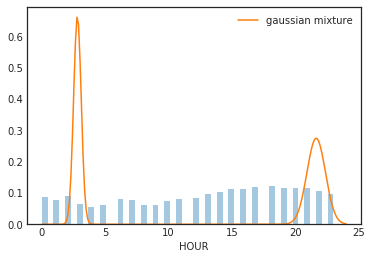

In [68]:
#mixture
sns.distplot(data, bins=50, kde=False, norm_hist=True)
g_both = [best_mix.pdf(e) for e in x]
plt.plot(x, g_both, label='gaussian mixture');
plt.legend();